In [1]:
import pandas as pd
import numpy as np
import collections

import torch

from acgan import torch_gan

%matplotlib inline

Using Theano backend.


In [2]:
gen = torch_gan.make_model_from_block(torch_gan.CNNTransposeBlock, 
                                       z_dim=100, 
                                       n_channels=[256, 128, 64, 32],
                                       kernel_sizes=[4],
                                       strides=[1, 1, 3, 2],
                                       paddings=[0, 1, 1, 1])

gen.add_module(name='output_conv', module=torch.nn.ConvTranspose2d(in_channels=32, out_channels=1, 
                                                                   kernel_size=3, stride=1, padding=1))
gen.add_module(name='output_activ', module=torch.nn.Tanh())

In [3]:
t_z = torch.randn(64, 100, 1, 1)#, device=self.device)

In [4]:
gen(t_z).shape

torch.Size([64, 1, 28, 28])

****

In [10]:
disc = torch_gan.make_model_from_block(torch_gan.CNNBlock,
                                       z_dim=1,
                                       n_channels=[32, 64, 128, 256],
                                       kernel_sizes=[4, 4, 3, 3],
                                       strides=[2, 2, 2, 2],
                                       paddings=[1, 1, 1, 1]
                                      )
disc.add_module(name='output_conv', module=torch.nn.Conv2d(256, 1, 2, stride=1))
disc.add_module(name='output_activ', module=torch.nn.Sigmoid())

In [11]:
disc_in = gen(t_z)

In [12]:
disc_in.shape

torch.Size([64, 1, 28, 28])

In [13]:
disc(disc_in).shape

torch.Size([64, 1, 1, 1])

***

In [14]:
import torch.utils.data
import torchvision.datasets as dset

import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt

In [15]:
# Root directory for dataset
dataroot = "~/datasets"

In [24]:
image_size = 28
batch_size = 128
workers = 4

In [25]:
dataset = dset.FashionMNIST(dataroot, train=True, 
                            transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]), 
                            
                            target_transform=None, download=True)

In [26]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=torch.utils.data.RandomSampler(dataset, 
                                                                                replacement=True,
                                                                                num_samples=200*batch_size),
                                         shuffle=False, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

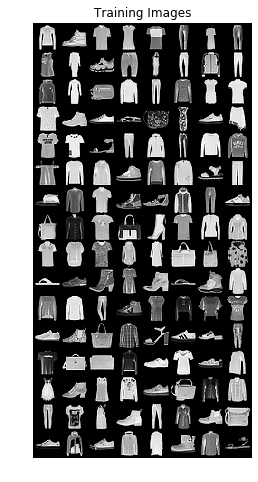

In [27]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [29]:
trainer = torch_gan.GANTrainer(gen, disc, dataloader,
                               n_samples = int(np.round(dataloader.sampler.num_samples/ dataloader.batch_size)))

In [30]:
from IPython.display import display
import torch
fixed_outputs = list()
output_every = 5
fixed_noise = torch.randn(4, 100, 1, 1, device=trainer.device)

batch_f = lambda _tr, _epoch: fixed_outputs.append(_tr.gen_model(fixed_noise).cpu().detach().numpy())

res = trainer.train(10, batch_cb_delta=output_every,
                    batch_callbacks=dict(batch_fixed_gen=batch_f))

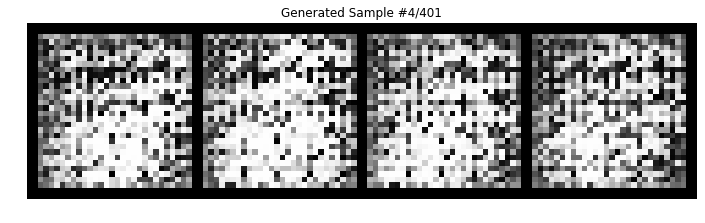

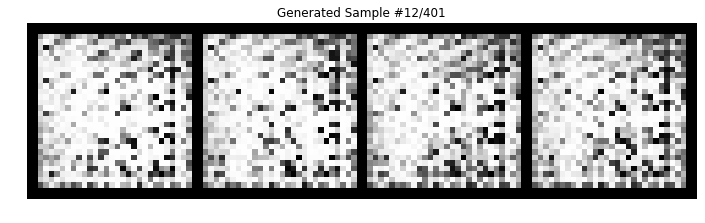

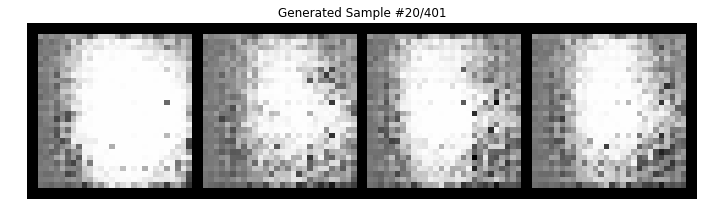

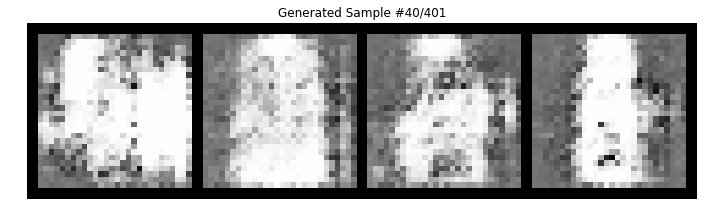

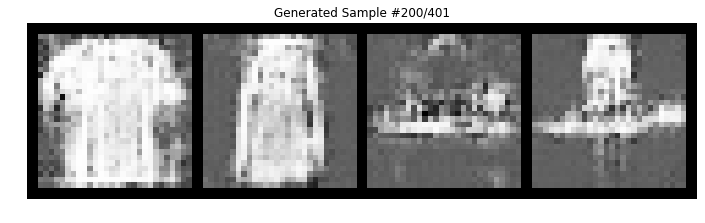

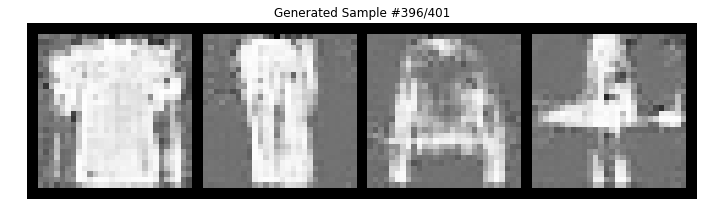

In [31]:
for _q in [0.01, 0.03, 0.05, 0.1, 0.5, 0.99]:
    _ix = int(len(fixed_outputs)*_q)
    trainer.display_batch(batch_data=torch.tensor(fixed_outputs[_ix]), figsize=(12, 12),
                         title='Generated Sample #%d/%d' % (_ix, len(fixed_outputs)));